**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D


np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
images_dir = '/home/phm/Images/Stardist/Maela/Train/'
X = sorted(glob(images_dir+'Raw/*.tif'))
Y = sorted(glob(images_dir+'Mask/*.tif'))


In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]


Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Split into train and validation datasets.

In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  20
- training:        17
- validation:       3


Training data consists of pairs of input image and label instances.

In [6]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

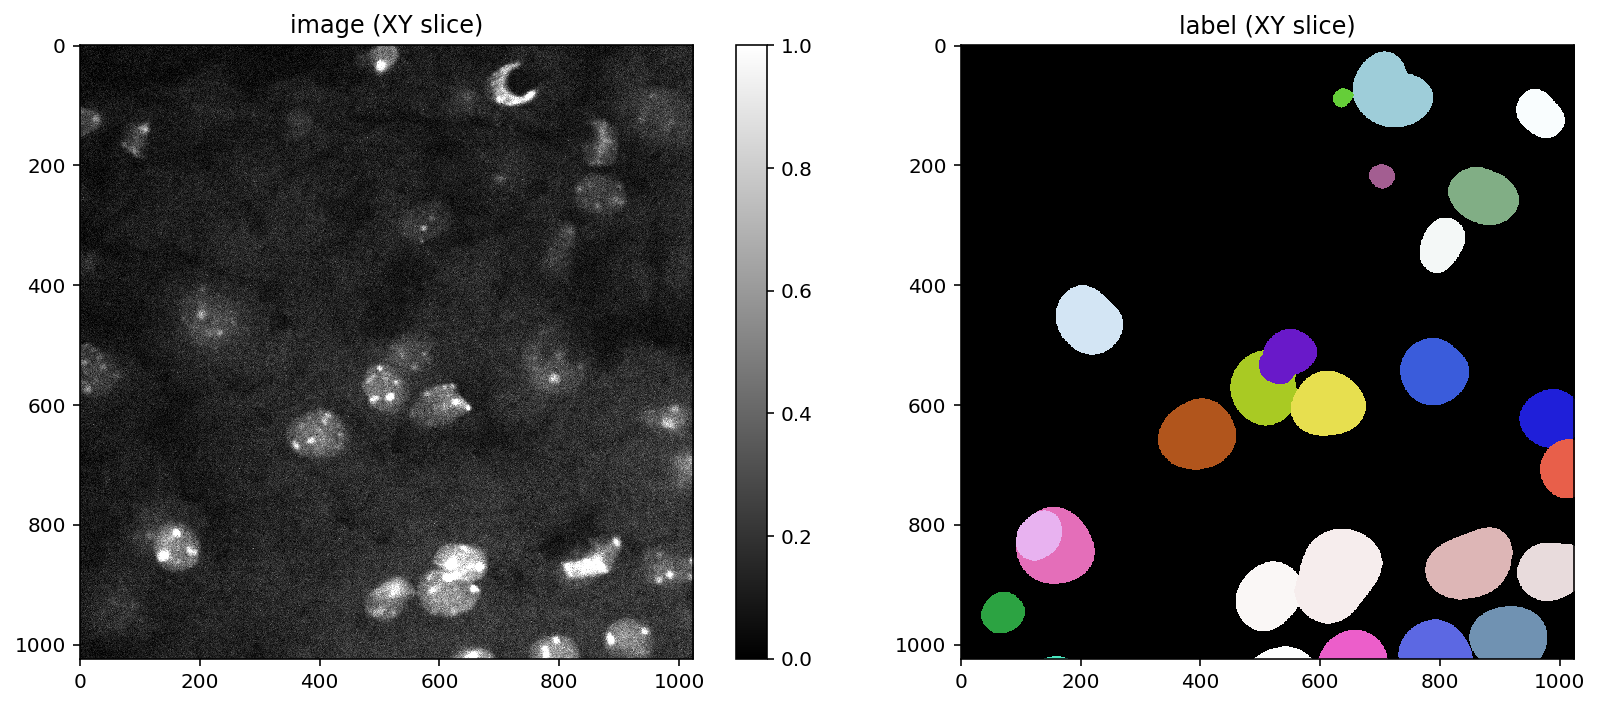

In [7]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [8]:
#print(Config3D.__doc__)

In [9]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (9.211538461538462, 1.0148305084745763, 1.0)


In [10]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 4 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    #train_patch_size = (10,24,24),
    train_patch_size = (10,128,128),
    train_batch_size = 4,
)
print(conf)
#vars(conf)

Config3D(anisotropy=(9.211538461538462, 1.0148305084745763, 1.0), axes='ZYXC', backbone='resnet', grid=(1, 4, 4), n_channel_in=1, n_channel_out=97, n_dim=3, n_rays=96, net_conv_after_resnet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (9.211538461538462, 1.0148305084745763, 1.0)}}, resnet_activation='relu', resnet_batch_norm=False, resnet_kernel_init='he_normal', resnet_kernel_size=(3, 3, 3), resnet_n_blocks=4, resnet_n_conv_per_block=3, resnet_n_filter_base=32, train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(10, 128, 128), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_

In [11]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    #limit_gpu_memory(32,0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [12]:
model = StarDist3D(conf, name='Fluo3D', basedir='/home/phm/Developpement/StarDist_Models/3D')

base_model.py (148): output path for model already exists, files may be overwritten: /home/phm/Developpement/StarDist_Models/3D/Fluo3D


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.538168, nms_thresh=0.3.


In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [13]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [ 13.   118.   119.75]
network field of view :  [17 49 49]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [14]:
def random_fliprot(img, mask, axis=None): 
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
            
    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y


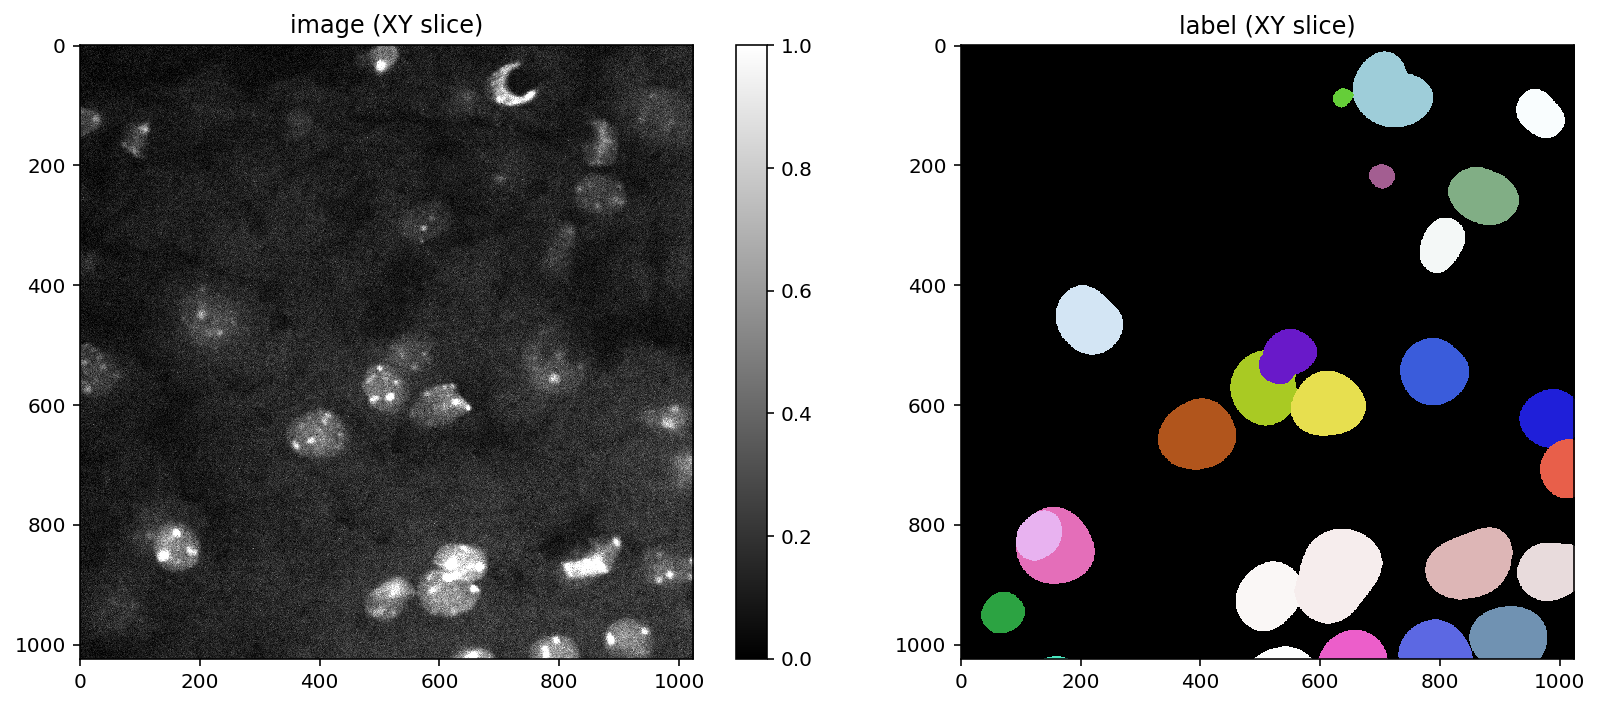

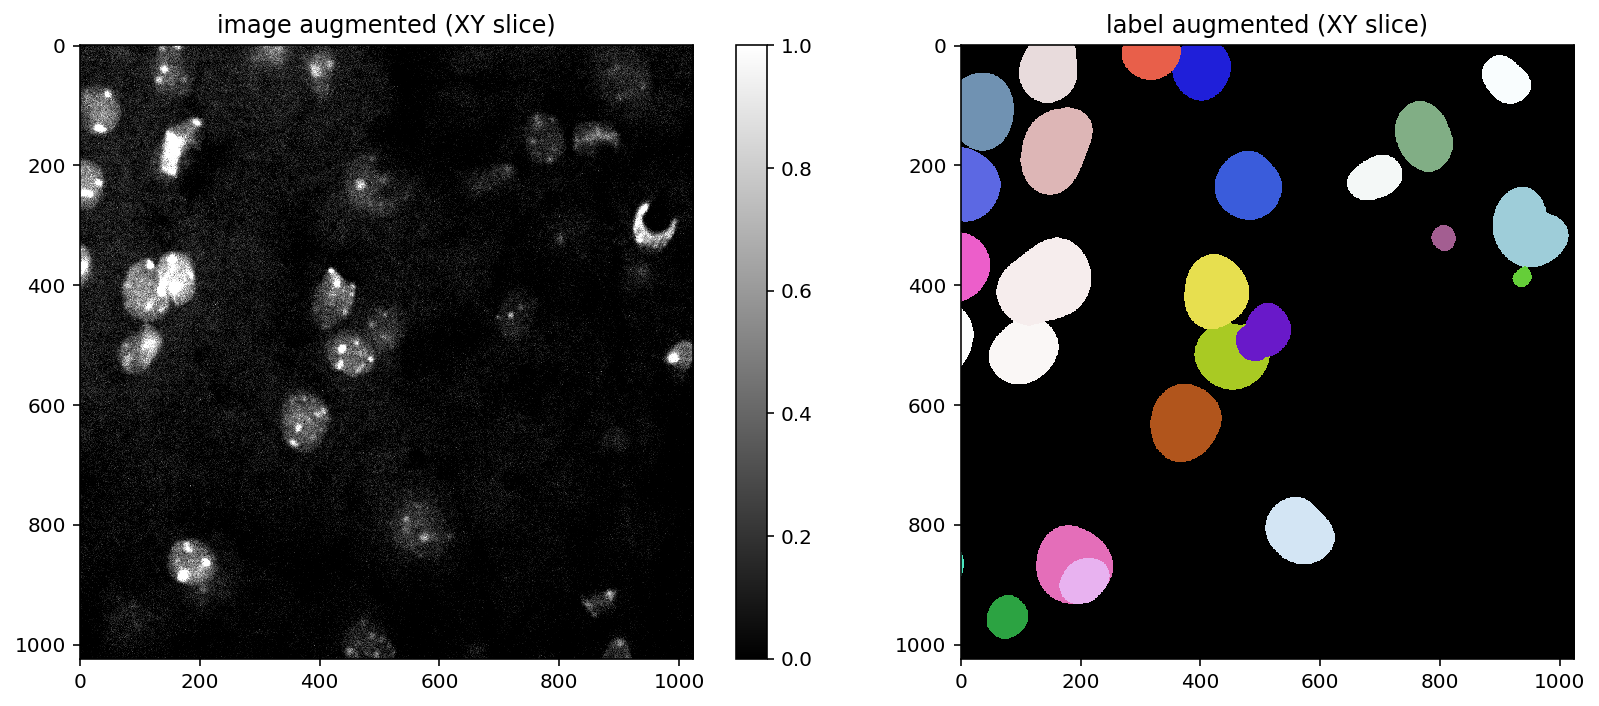

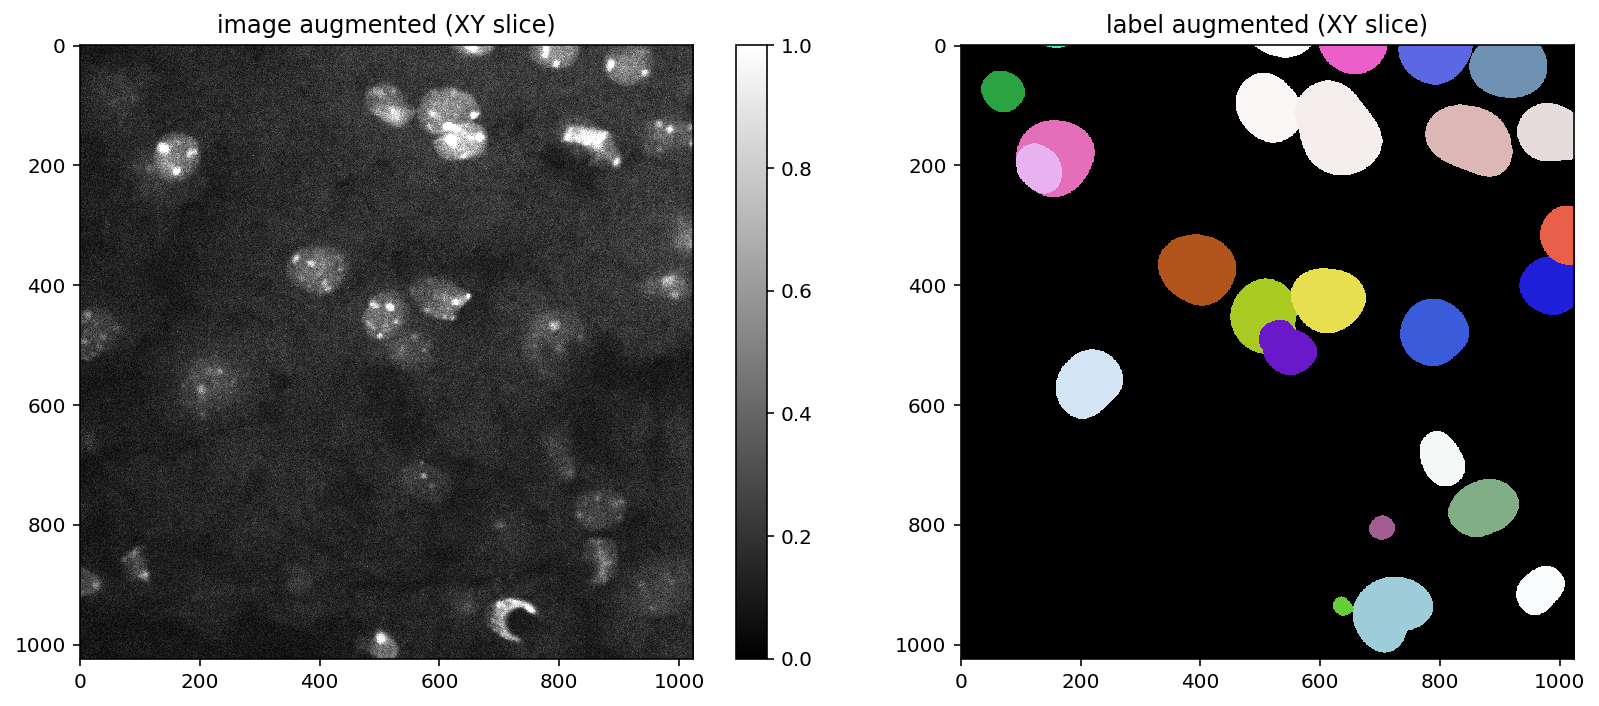

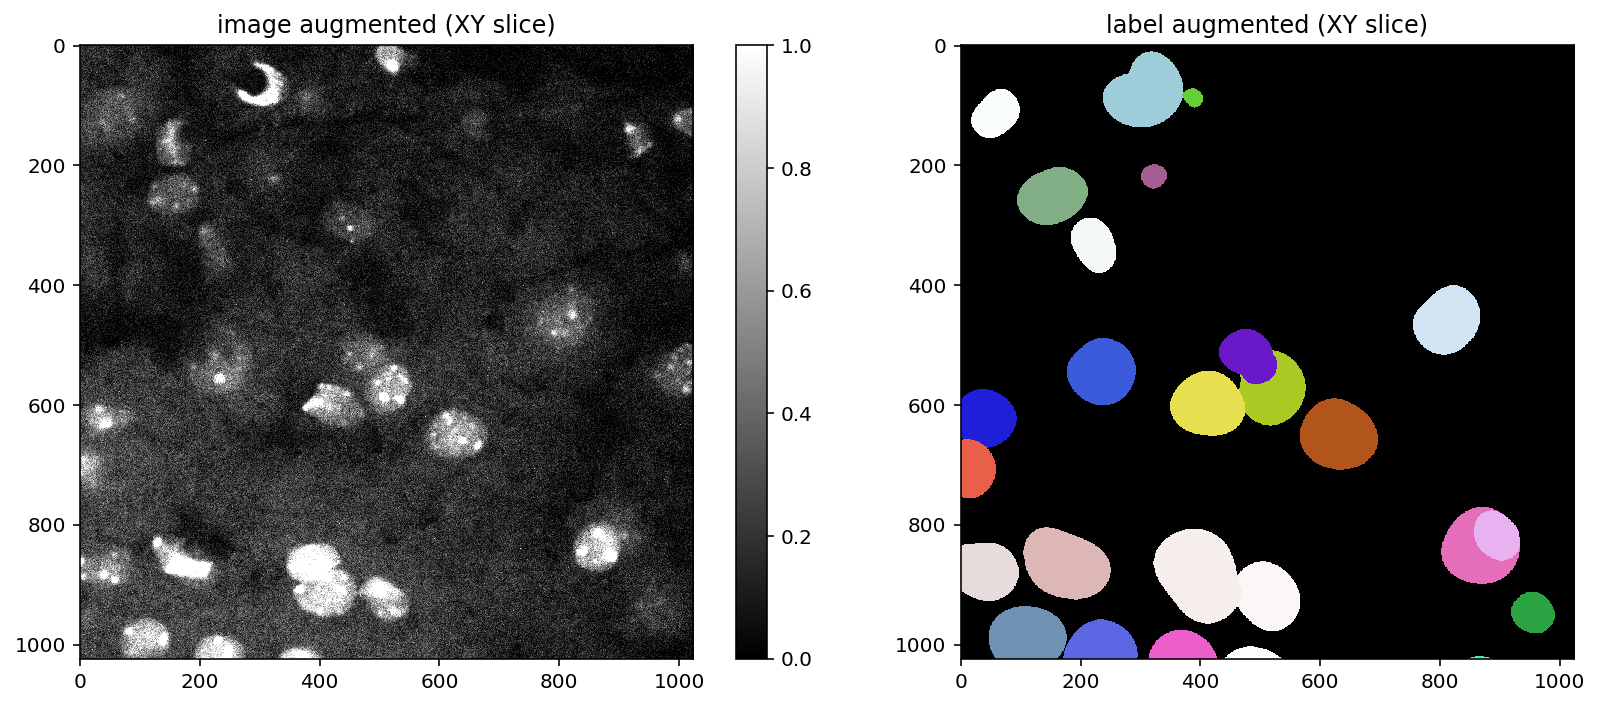

In [15]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [16]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
100/100 [==============================] - 100s 967ms/step - loss: 5.3183 - prob_loss: 0.8434 - dist_loss: 22.3744 - prob_kld: 0.4947 - dist_relevant_mae: 22.3740 - dist_relevant_mse: 874.1720 - val_loss: 2.8425 - val_prob_loss: 0.3924 - val_dist_loss: 12.2505 - val_prob_kld: 0.2972 - val_dist_relevant_mae: 12.2496 - val_dist_relevant_mse: 323.9790
Epoch 2/400
100/100 [==============================] - 101s 1s/step - loss: 3.4344 - prob_loss: 0.4838 - dist_loss: 14.7534 - prob_kld: 0.3092 - dist_relevant_mae: 14.7523 - dist_relevant_mse: 450.9852 - val_loss: 2.5066 - val_prob_loss: 0.3010 - val_dist_loss: 11.0276 - val_prob_kld: 0.2058 - val_dist_relevant_mae: 11.0265 - val_dist_relevant_mse: 286.9232
Epoch 3/400
100/100 [==============================] - 103s 1s/step - loss: 2.8944 - prob_loss: 0.4041 - dist_loss: 12.4513 - prob_kld: 0.2194 - dist_relevant_mae: 12.4497 - dist_relevant_mse: 334.8621 - val_loss: 2.2045 - val_prob_loss: 0.3212 - val_dist_loss: 9.4168 - val_pr

Epoch 24/400
100/100 [==============================] - 102s 1s/step - loss: 1.7377 - prob_loss: 0.2656 - dist_loss: 7.3606 - prob_kld: 0.1030 - dist_relevant_mae: 7.3588 - dist_relevant_mse: 140.0080 - val_loss: 1.1583 - val_prob_loss: 0.1400 - val_dist_loss: 5.0916 - val_prob_kld: 0.0448 - val_dist_relevant_mae: 5.0901 - val_dist_relevant_mse: 73.9956
Epoch 25/400
100/100 [==============================] - 102s 1s/step - loss: 1.7893 - prob_loss: 0.2762 - dist_loss: 7.5651 - prob_kld: 0.1042 - dist_relevant_mae: 7.5632 - dist_relevant_mse: 148.1550 - val_loss: 1.1932 - val_prob_loss: 0.1316 - val_dist_loss: 5.3078 - val_prob_kld: 0.0364 - val_dist_relevant_mae: 5.3064 - val_dist_relevant_mse: 72.9579
Epoch 26/400
100/100 [==============================] - 102s 1s/step - loss: 1.7866 - prob_loss: 0.2774 - dist_loss: 7.5459 - prob_kld: 0.1137 - dist_relevant_mae: 7.5440 - dist_relevant_mse: 147.8107 - val_loss: 1.1758 - val_prob_loss: 0.1318 - val_dist_loss: 5.2200 - val_prob_kld: 0.03

100/100 [==============================] - 102s 1s/step - loss: 1.6715 - prob_loss: 0.2744 - dist_loss: 6.9854 - prob_kld: 0.0960 - dist_relevant_mae: 6.9835 - dist_relevant_mse: 134.7790 - val_loss: 0.9553 - val_prob_loss: 0.1292 - val_dist_loss: 4.1305 - val_prob_kld: 0.0340 - val_dist_relevant_mae: 4.1285 - val_dist_relevant_mse: 50.6915
Epoch 48/400
100/100 [==============================] - 102s 1s/step - loss: 1.6526 - prob_loss: 0.2734 - dist_loss: 6.8959 - prob_kld: 0.1039 - dist_relevant_mae: 6.8940 - dist_relevant_mse: 131.6681 - val_loss: 0.9595 - val_prob_loss: 0.1259 - val_dist_loss: 4.1681 - val_prob_kld: 0.0306 - val_dist_relevant_mae: 4.1662 - val_dist_relevant_mse: 49.6682
Epoch 49/400
100/100 [==============================] - 102s 1s/step - loss: 1.6823 - prob_loss: 0.2807 - dist_loss: 7.0081 - prob_kld: 0.0980 - dist_relevant_mae: 7.0062 - dist_relevant_mse: 138.5804 - val_loss: 1.0141 - val_prob_loss: 0.1312 - val_dist_loss: 4.4145 - val_prob_kld: 0.0360 - val_dist

100/100 [==============================] - 102s 1s/step - loss: 1.5873 - prob_loss: 0.2636 - dist_loss: 6.6182 - prob_kld: 0.0954 - dist_relevant_mae: 6.6163 - dist_relevant_mse: 125.4152 - val_loss: 1.0227 - val_prob_loss: 0.1237 - val_dist_loss: 4.4950 - val_prob_kld: 0.0285 - val_dist_relevant_mae: 4.4933 - val_dist_relevant_mse: 61.8151
Epoch 71/400
100/100 [==============================] - 102s 1s/step - loss: 1.5375 - prob_loss: 0.2684 - dist_loss: 6.3453 - prob_kld: 0.0951 - dist_relevant_mae: 6.3434 - dist_relevant_mse: 115.3256 - val_loss: 0.9533 - val_prob_loss: 0.1259 - val_dist_loss: 4.1368 - val_prob_kld: 0.0307 - val_dist_relevant_mae: 4.1351 - val_dist_relevant_mse: 49.0607
Epoch 72/400
100/100 [==============================] - 102s 1s/step - loss: 1.5719 - prob_loss: 0.2651 - dist_loss: 6.5338 - prob_kld: 0.0917 - dist_relevant_mae: 6.5319 - dist_relevant_mse: 121.1447 - val_loss: 0.9804 - val_prob_loss: 0.1408 - val_dist_loss: 4.1979 - val_prob_kld: 0.0456 - val_dist

100/100 [==============================] - 104s 1s/step - loss: 1.5407 - prob_loss: 0.2671 - dist_loss: 6.3681 - prob_kld: 0.0866 - dist_relevant_mae: 6.3661 - dist_relevant_mse: 120.1098 - val_loss: 1.0057 - val_prob_loss: 0.1338 - val_dist_loss: 4.3595 - val_prob_kld: 0.0386 - val_dist_relevant_mae: 4.3576 - val_dist_relevant_mse: 55.0298
Epoch 94/400
100/100 [==============================] - 102s 1s/step - loss: 1.5161 - prob_loss: 0.2810 - dist_loss: 6.1752 - prob_kld: 0.0946 - dist_relevant_mae: 6.1733 - dist_relevant_mse: 114.8320 - val_loss: 0.9017 - val_prob_loss: 0.1363 - val_dist_loss: 3.8268 - val_prob_kld: 0.0411 - val_dist_relevant_mae: 3.8248 - val_dist_relevant_mse: 45.0995
Epoch 95/400
100/100 [==============================] - 103s 1s/step - loss: 1.4634 - prob_loss: 0.2400 - dist_loss: 6.1170 - prob_kld: 0.0816 - dist_relevant_mae: 6.1151 - dist_relevant_mse: 111.2783 - val_loss: 1.0146 - val_prob_loss: 0.1388 - val_dist_loss: 4.3793 - val_prob_kld: 0.0436 - val_dist

100/100 [==============================] - 102s 1s/step - loss: 1.5299 - prob_loss: 0.2863 - dist_loss: 6.2182 - prob_kld: 0.0901 - dist_relevant_mae: 6.2162 - dist_relevant_mse: 119.1111 - val_loss: 0.8345 - val_prob_loss: 0.1304 - val_dist_loss: 3.5204 - val_prob_kld: 0.0352 - val_dist_relevant_mae: 3.5186 - val_dist_relevant_mse: 40.0114
Epoch 117/400
100/100 [==============================] - 102s 1s/step - loss: 1.5297 - prob_loss: 0.2669 - dist_loss: 6.3139 - prob_kld: 0.1003 - dist_relevant_mae: 6.3119 - dist_relevant_mse: 123.3308 - val_loss: 0.8846 - val_prob_loss: 0.1233 - val_dist_loss: 3.8064 - val_prob_kld: 0.0281 - val_dist_relevant_mae: 3.8048 - val_dist_relevant_mse: 44.7716
Epoch 118/400
100/100 [==============================] - 102s 1s/step - loss: 1.5284 - prob_loss: 0.2660 - dist_loss: 6.3123 - prob_kld: 0.0800 - dist_relevant_mae: 6.3105 - dist_relevant_mse: 122.0972 - val_loss: 0.9277 - val_prob_loss: 0.1315 - val_dist_loss: 3.9811 - val_prob_kld: 0.0362 - val_di

Epoch 139/400
100/100 [==============================] - 102s 1s/step - loss: 1.4831 - prob_loss: 0.2594 - dist_loss: 6.1183 - prob_kld: 0.0852 - dist_relevant_mae: 6.1164 - dist_relevant_mse: 116.3944 - val_loss: 0.9145 - val_prob_loss: 0.1335 - val_dist_loss: 3.9047 - val_prob_kld: 0.0383 - val_dist_relevant_mae: 3.9034 - val_dist_relevant_mse: 49.7680
Epoch 140/400
100/100 [==============================] - 102s 1s/step - loss: 1.4853 - prob_loss: 0.2549 - dist_loss: 6.1518 - prob_kld: 0.0819 - dist_relevant_mae: 6.1500 - dist_relevant_mse: 116.1677 - val_loss: 0.8353 - val_prob_loss: 0.1219 - val_dist_loss: 3.5669 - val_prob_kld: 0.0267 - val_dist_relevant_mae: 3.5648 - val_dist_relevant_mse: 40.5265
Epoch 141/400
100/100 [==============================] - 102s 1s/step - loss: 1.5416 - prob_loss: 0.2743 - dist_loss: 6.3368 - prob_kld: 0.0827 - dist_relevant_mae: 6.3348 - dist_relevant_mse: 122.3743 - val_loss: 0.9201 - val_prob_loss: 0.1298 - val_dist_loss: 3.9515 - val_prob_kld: 0

Epoch 162/400
100/100 [==============================] - 102s 1s/step - loss: 1.3924 - prob_loss: 0.2442 - dist_loss: 5.7411 - prob_kld: 0.0742 - dist_relevant_mae: 5.7391 - dist_relevant_mse: 105.3354 - val_loss: 0.8173 - val_prob_loss: 0.1231 - val_dist_loss: 3.4713 - val_prob_kld: 0.0279 - val_dist_relevant_mae: 3.4697 - val_dist_relevant_mse: 40.8404
Epoch 163/400
100/100 [==============================] - 102s 1s/step - loss: 1.4350 - prob_loss: 0.2409 - dist_loss: 5.9705 - prob_kld: 0.0816 - dist_relevant_mae: 5.9686 - dist_relevant_mse: 111.0329 - val_loss: 0.9096 - val_prob_loss: 0.1222 - val_dist_loss: 3.9371 - val_prob_kld: 0.0270 - val_dist_relevant_mae: 3.9353 - val_dist_relevant_mse: 46.8074
Epoch 164/400
100/100 [==============================] - 102s 1s/step - loss: 1.4814 - prob_loss: 0.2434 - dist_loss: 6.1900 - prob_kld: 0.0794 - dist_relevant_mae: 6.1881 - dist_relevant_mse: 119.6908 - val_loss: 0.8084 - val_prob_loss: 0.1229 - val_dist_loss: 3.4271 - val_prob_kld: 0

Epoch 185/400
100/100 [==============================] - 102s 1s/step - loss: 1.4299 - prob_loss: 0.2459 - dist_loss: 5.9202 - prob_kld: 0.0814 - dist_relevant_mae: 5.9181 - dist_relevant_mse: 112.7996 - val_loss: 0.7740 - val_prob_loss: 0.1275 - val_dist_loss: 3.2328 - val_prob_kld: 0.0323 - val_dist_relevant_mae: 3.2312 - val_dist_relevant_mse: 34.2117
Epoch 186/400
100/100 [==============================] - 102s 1s/step - loss: 1.3808 - prob_loss: 0.2309 - dist_loss: 5.7495 - prob_kld: 0.0699 - dist_relevant_mae: 5.7477 - dist_relevant_mse: 106.0446 - val_loss: 0.8037 - val_prob_loss: 0.1207 - val_dist_loss: 3.4151 - val_prob_kld: 0.0255 - val_dist_relevant_mae: 3.4133 - val_dist_relevant_mse: 36.8948
Epoch 187/400
100/100 [==============================] - 102s 1s/step - loss: 1.4425 - prob_loss: 0.2545 - dist_loss: 5.9398 - prob_kld: 0.0803 - dist_relevant_mae: 5.9379 - dist_relevant_mse: 110.3175 - val_loss: 0.8638 - val_prob_loss: 0.1287 - val_dist_loss: 3.6755 - val_prob_kld: 0

Epoch 208/400
100/100 [==============================] - 102s 1s/step - loss: 1.4225 - prob_loss: 0.2585 - dist_loss: 5.8199 - prob_kld: 0.0804 - dist_relevant_mae: 5.8181 - dist_relevant_mse: 108.4770 - val_loss: 0.8058 - val_prob_loss: 0.1241 - val_dist_loss: 3.4085 - val_prob_kld: 0.0289 - val_dist_relevant_mae: 3.4069 - val_dist_relevant_mse: 38.4222
Epoch 209/400
100/100 [==============================] - 102s 1s/step - loss: 1.4554 - prob_loss: 0.2554 - dist_loss: 6.0002 - prob_kld: 0.0756 - dist_relevant_mae: 5.9983 - dist_relevant_mse: 117.5414 - val_loss: 0.7984 - val_prob_loss: 0.1212 - val_dist_loss: 3.3859 - val_prob_kld: 0.0260 - val_dist_relevant_mae: 3.3843 - val_dist_relevant_mse: 37.0936
Epoch 210/400
100/100 [==============================] - 102s 1s/step - loss: 1.3895 - prob_loss: 0.2310 - dist_loss: 5.7926 - prob_kld: 0.0718 - dist_relevant_mae: 5.7908 - dist_relevant_mse: 111.9951 - val_loss: 0.8136 - val_prob_loss: 0.1237 - val_dist_loss: 3.4495 - val_prob_kld: 0

Epoch 231/400
100/100 [==============================] - 102s 1s/step - loss: 1.3775 - prob_loss: 0.2436 - dist_loss: 5.6691 - prob_kld: 0.0783 - dist_relevant_mae: 5.6673 - dist_relevant_mse: 103.4293 - val_loss: 0.7668 - val_prob_loss: 0.1204 - val_dist_loss: 3.2317 - val_prob_kld: 0.0252 - val_dist_relevant_mae: 3.2304 - val_dist_relevant_mse: 36.1789
Epoch 232/400
100/100 [==============================] - 102s 1s/step - loss: 1.2984 - prob_loss: 0.2392 - dist_loss: 5.2958 - prob_kld: 0.0717 - dist_relevant_mae: 5.2939 - dist_relevant_mse: 93.8185 - val_loss: 0.8672 - val_prob_loss: 0.1245 - val_dist_loss: 3.7137 - val_prob_kld: 0.0292 - val_dist_relevant_mae: 3.7123 - val_dist_relevant_mse: 45.1350
Epoch 233/400
100/100 [==============================] - 102s 1s/step - loss: 1.4025 - prob_loss: 0.2523 - dist_loss: 5.7510 - prob_kld: 0.0730 - dist_relevant_mae: 5.7492 - dist_relevant_mse: 108.2681 - val_loss: 0.7607 - val_prob_loss: 0.1229 - val_dist_loss: 3.1888 - val_prob_kld: 0.

Epoch 254/400
100/100 [==============================] - 102s 1s/step - loss: 1.3629 - prob_loss: 0.2466 - dist_loss: 5.5814 - prob_kld: 0.0768 - dist_relevant_mae: 5.5795 - dist_relevant_mse: 103.4372 - val_loss: 0.7592 - val_prob_loss: 0.1199 - val_dist_loss: 3.1963 - val_prob_kld: 0.0247 - val_dist_relevant_mae: 3.1945 - val_dist_relevant_mse: 35.8180
Epoch 255/400
100/100 [==============================] - 102s 1s/step - loss: 1.3421 - prob_loss: 0.2268 - dist_loss: 5.5763 - prob_kld: 0.0666 - dist_relevant_mae: 5.5744 - dist_relevant_mse: 102.6718 - val_loss: 0.7567 - val_prob_loss: 0.1241 - val_dist_loss: 3.1630 - val_prob_kld: 0.0289 - val_dist_relevant_mae: 3.1615 - val_dist_relevant_mse: 33.8418
Epoch 256/400
100/100 [==============================] - 102s 1s/step - loss: 1.3948 - prob_loss: 0.2438 - dist_loss: 5.7553 - prob_kld: 0.0728 - dist_relevant_mae: 5.7535 - dist_relevant_mse: 109.7801 - val_loss: 0.7676 - val_prob_loss: 0.1215 - val_dist_loss: 3.2306 - val_prob_kld: 0

Epoch 277/400
100/100 [==============================] - 102s 1s/step - loss: 1.3045 - prob_loss: 0.2427 - dist_loss: 5.3091 - prob_kld: 0.0683 - dist_relevant_mae: 5.3072 - dist_relevant_mse: 93.4113 - val_loss: 0.7827 - val_prob_loss: 0.1198 - val_dist_loss: 3.3144 - val_prob_kld: 0.0246 - val_dist_relevant_mae: 3.3127 - val_dist_relevant_mse: 36.4939
Epoch 278/400
100/100 [==============================] - 102s 1s/step - loss: 1.3917 - prob_loss: 0.2432 - dist_loss: 5.7423 - prob_kld: 0.0732 - dist_relevant_mae: 5.7405 - dist_relevant_mse: 105.3671 - val_loss: 0.7378 - val_prob_loss: 0.1245 - val_dist_loss: 3.0665 - val_prob_kld: 0.0293 - val_dist_relevant_mae: 3.0649 - val_dist_relevant_mse: 32.8779
Epoch 279/400
100/100 [==============================] - 102s 1s/step - loss: 1.3724 - prob_loss: 0.2435 - dist_loss: 5.6446 - prob_kld: 0.0673 - dist_relevant_mae: 5.6428 - dist_relevant_mse: 104.8997 - val_loss: 0.7349 - val_prob_loss: 0.1218 - val_dist_loss: 3.0660 - val_prob_kld: 0.

Epoch 300/400
100/100 [==============================] - 102s 1s/step - loss: 1.3616 - prob_loss: 0.2469 - dist_loss: 5.5736 - prob_kld: 0.0738 - dist_relevant_mae: 5.5717 - dist_relevant_mse: 104.2534 - val_loss: 0.8301 - val_prob_loss: 0.1299 - val_dist_loss: 3.5007 - val_prob_kld: 0.0347 - val_dist_relevant_mae: 3.4992 - val_dist_relevant_mse: 44.5868
Epoch 301/400
100/100 [==============================] - 102s 1s/step - loss: 1.4190 - prob_loss: 0.2534 - dist_loss: 5.8278 - prob_kld: 0.0787 - dist_relevant_mae: 5.8259 - dist_relevant_mse: 112.2522 - val_loss: 0.7793 - val_prob_loss: 0.1212 - val_dist_loss: 3.2906 - val_prob_kld: 0.0260 - val_dist_relevant_mae: 3.2891 - val_dist_relevant_mse: 38.1070
Epoch 302/400
100/100 [==============================] - 102s 1s/step - loss: 1.3781 - prob_loss: 0.2458 - dist_loss: 5.6616 - prob_kld: 0.0675 - dist_relevant_mae: 5.6598 - dist_relevant_mse: 105.0764 - val_loss: 0.7278 - val_prob_loss: 0.1242 - val_dist_loss: 3.0182 - val_prob_kld: 0

Epoch 323/400
100/100 [==============================] - 102s 1s/step - loss: 1.3936 - prob_loss: 0.2689 - dist_loss: 5.6234 - prob_kld: 0.0852 - dist_relevant_mae: 5.6215 - dist_relevant_mse: 106.1433 - val_loss: 0.7517 - val_prob_loss: 0.1185 - val_dist_loss: 3.1662 - val_prob_kld: 0.0233 - val_dist_relevant_mae: 3.1644 - val_dist_relevant_mse: 34.8767
Epoch 324/400
100/100 [==============================] - 102s 1s/step - loss: 1.3692 - prob_loss: 0.2447 - dist_loss: 5.6223 - prob_kld: 0.0701 - dist_relevant_mae: 5.6204 - dist_relevant_mse: 107.6447 - val_loss: 0.8077 - val_prob_loss: 0.1389 - val_dist_loss: 3.3442 - val_prob_kld: 0.0437 - val_dist_relevant_mae: 3.3425 - val_dist_relevant_mse: 38.4899
Epoch 325/400
100/100 [==============================] - 102s 1s/step - loss: 1.3879 - prob_loss: 0.2545 - dist_loss: 5.6673 - prob_kld: 0.0773 - dist_relevant_mae: 5.6655 - dist_relevant_mse: 106.2284 - val_loss: 0.7577 - val_prob_loss: 0.1254 - val_dist_loss: 3.1617 - val_prob_kld: 0

Epoch 346/400
100/100 [==============================] - 102s 1s/step - loss: 1.3265 - prob_loss: 0.2357 - dist_loss: 5.4536 - prob_kld: 0.0685 - dist_relevant_mae: 5.4519 - dist_relevant_mse: 102.5877 - val_loss: 0.7470 - val_prob_loss: 0.1221 - val_dist_loss: 3.1245 - val_prob_kld: 0.0269 - val_dist_relevant_mae: 3.1231 - val_dist_relevant_mse: 34.6787
Epoch 347/400
100/100 [==============================] - 102s 1s/step - loss: 1.3675 - prob_loss: 0.2544 - dist_loss: 5.5655 - prob_kld: 0.0749 - dist_relevant_mae: 5.5637 - dist_relevant_mse: 104.2508 - val_loss: 0.7697 - val_prob_loss: 0.1243 - val_dist_loss: 3.2272 - val_prob_kld: 0.0291 - val_dist_relevant_mae: 3.2258 - val_dist_relevant_mse: 35.3904
Epoch 348/400
100/100 [==============================] - 102s 1s/step - loss: 1.3701 - prob_loss: 0.2475 - dist_loss: 5.6132 - prob_kld: 0.0698 - dist_relevant_mae: 5.6113 - dist_relevant_mse: 108.9503 - val_loss: 0.7227 - val_prob_loss: 0.1230 - val_dist_loss: 2.9987 - val_prob_kld: 0

Epoch 369/400
100/100 [==============================] - 102s 1s/step - loss: 1.2908 - prob_loss: 0.2310 - dist_loss: 5.2988 - prob_kld: 0.0667 - dist_relevant_mae: 5.2970 - dist_relevant_mse: 96.7944 - val_loss: 0.7227 - val_prob_loss: 0.1215 - val_dist_loss: 3.0063 - val_prob_kld: 0.0262 - val_dist_relevant_mae: 3.0045 - val_dist_relevant_mse: 31.8446
Epoch 370/400
100/100 [==============================] - 102s 1s/step - loss: 1.4071 - prob_loss: 0.2599 - dist_loss: 5.7363 - prob_kld: 0.0735 - dist_relevant_mae: 5.7344 - dist_relevant_mse: 110.8839 - val_loss: 0.6907 - val_prob_loss: 0.1244 - val_dist_loss: 2.8315 - val_prob_kld: 0.0292 - val_dist_relevant_mae: 2.8298 - val_dist_relevant_mse: 29.5181
Epoch 371/400
100/100 [==============================] - 102s 1s/step - loss: 1.3466 - prob_loss: 0.2244 - dist_loss: 5.6106 - prob_kld: 0.0677 - dist_relevant_mae: 5.6087 - dist_relevant_mse: 105.8442 - val_loss: 0.7586 - val_prob_loss: 0.1222 - val_dist_loss: 3.1822 - val_prob_kld: 0.

Epoch 392/400
100/100 [==============================] - 102s 1s/step - loss: 1.3792 - prob_loss: 0.2455 - dist_loss: 5.6683 - prob_kld: 0.0717 - dist_relevant_mae: 5.6664 - dist_relevant_mse: 109.3203 - val_loss: 0.7832 - val_prob_loss: 0.1236 - val_dist_loss: 3.2979 - val_prob_kld: 0.0284 - val_dist_relevant_mae: 3.2960 - val_dist_relevant_mse: 38.9291
Epoch 393/400
100/100 [==============================] - 102s 1s/step - loss: 1.3771 - prob_loss: 0.2489 - dist_loss: 5.6410 - prob_kld: 0.0751 - dist_relevant_mae: 5.6390 - dist_relevant_mse: 106.0134 - val_loss: 0.7053 - val_prob_loss: 0.1245 - val_dist_loss: 2.9036 - val_prob_kld: 0.0293 - val_dist_relevant_mae: 2.9020 - val_dist_relevant_mse: 31.5493
Epoch 394/400
100/100 [==============================] - 102s 1s/step - loss: 1.3236 - prob_loss: 0.2524 - dist_loss: 5.3559 - prob_kld: 0.0715 - dist_relevant_mae: 5.3540 - dist_relevant_mse: 98.7090 - val_loss: 0.7509 - val_prob_loss: 0.1281 - val_dist_loss: 3.1140 - val_prob_kld: 0.

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [17]:
if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [09:46<03:15, 39.08s/it, 0.396 -> 0.359]


Using optimized values: prob_thresh=0.394241, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [ ]:
# help(matching)

First predict the labels for all validation images:

In [18]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 3/3 [01:34<00:00, 31.34s/it]


Plot a GT/prediction example  

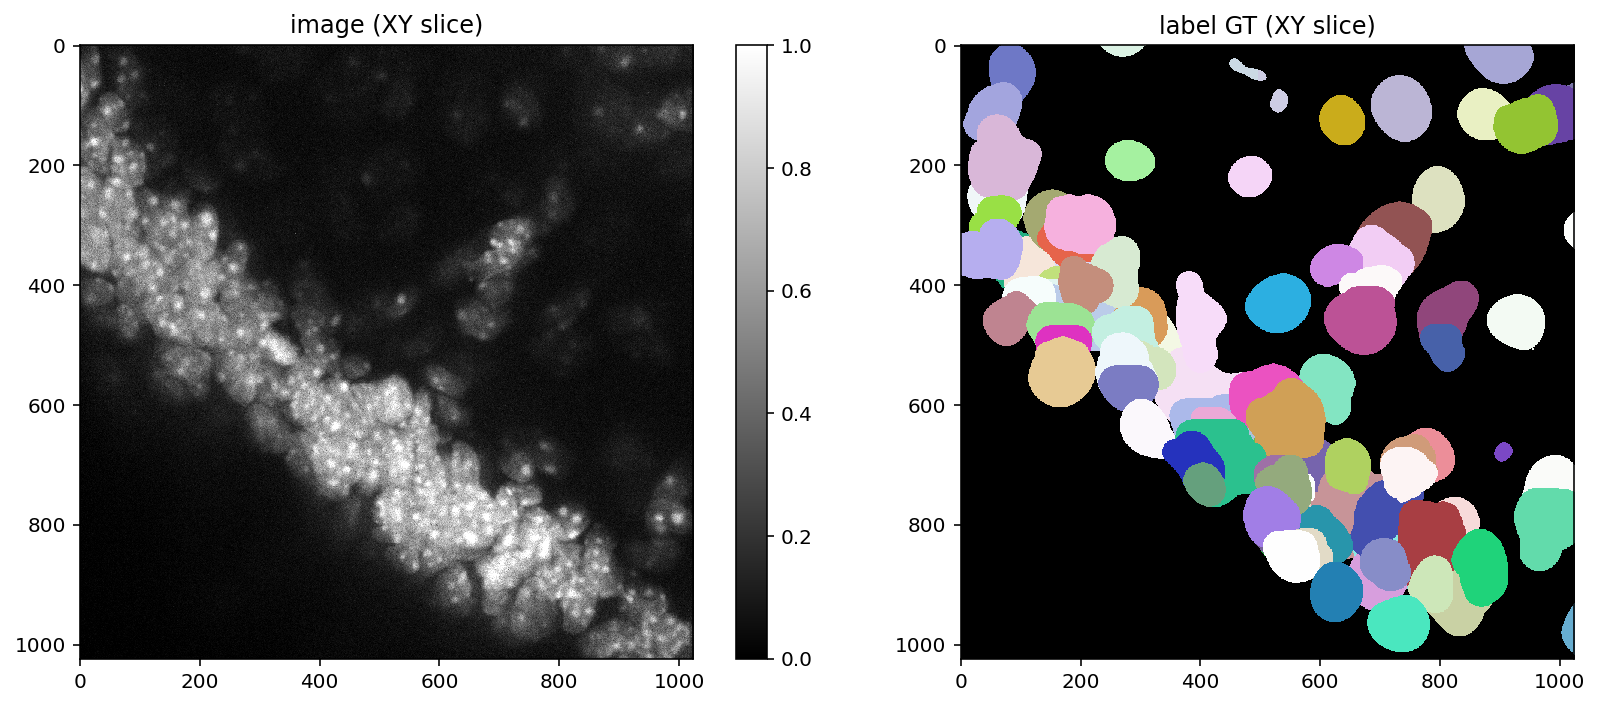

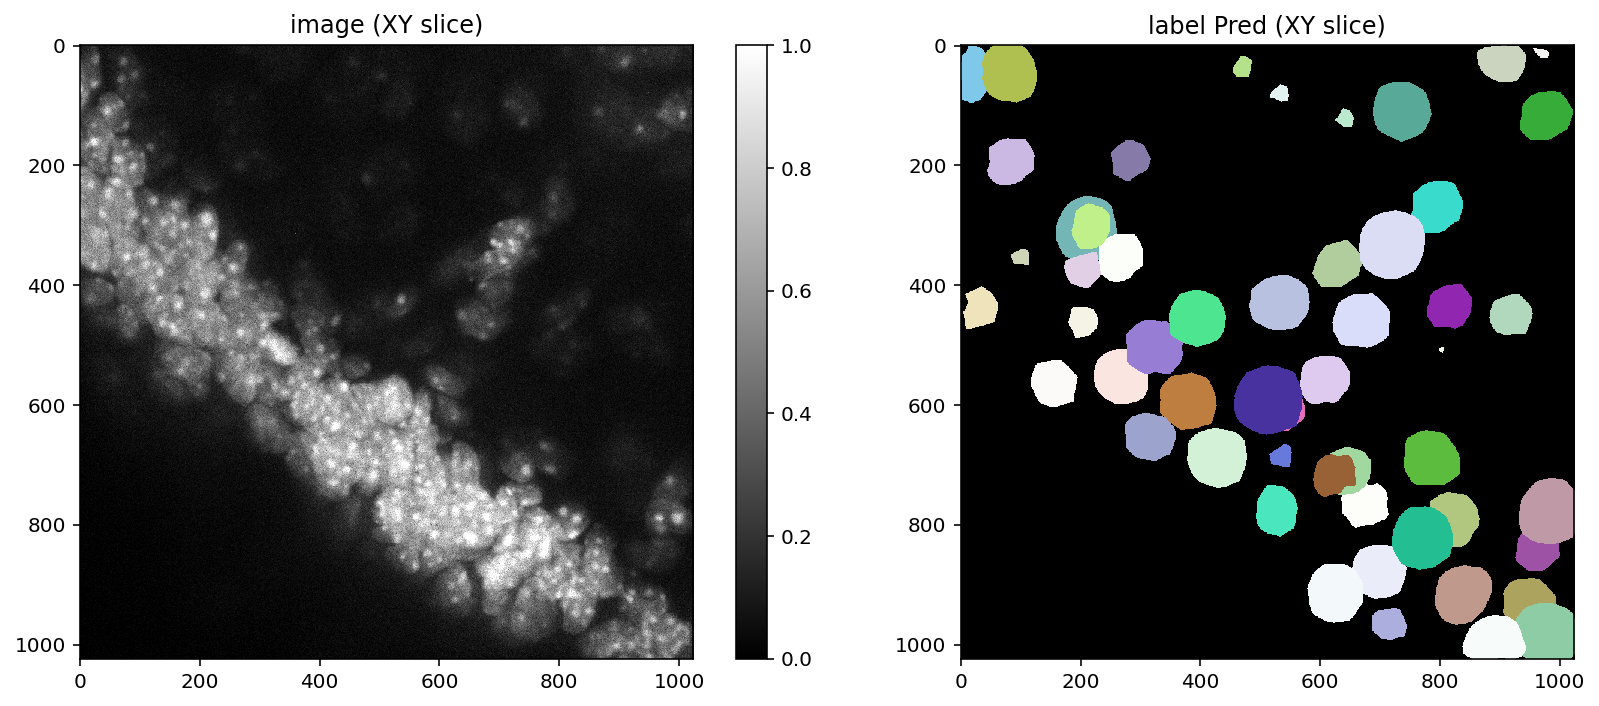

In [19]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [20]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:22<00:00,  2.45s/it]


Example: Print all available matching statistics for $\tau=0.7$

In [21]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=142, tp=63, fn=207, precision=0.3073170731707317, recall=0.23333333333333334, accuracy=0.1529126213592233, f1=0.26526315789473687, n_true=270, n_pred=205, mean_true_score=0.17772512523323983, mean_matched_score=0.7616791081424564, panoptic_quality=0.20204540552831474, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

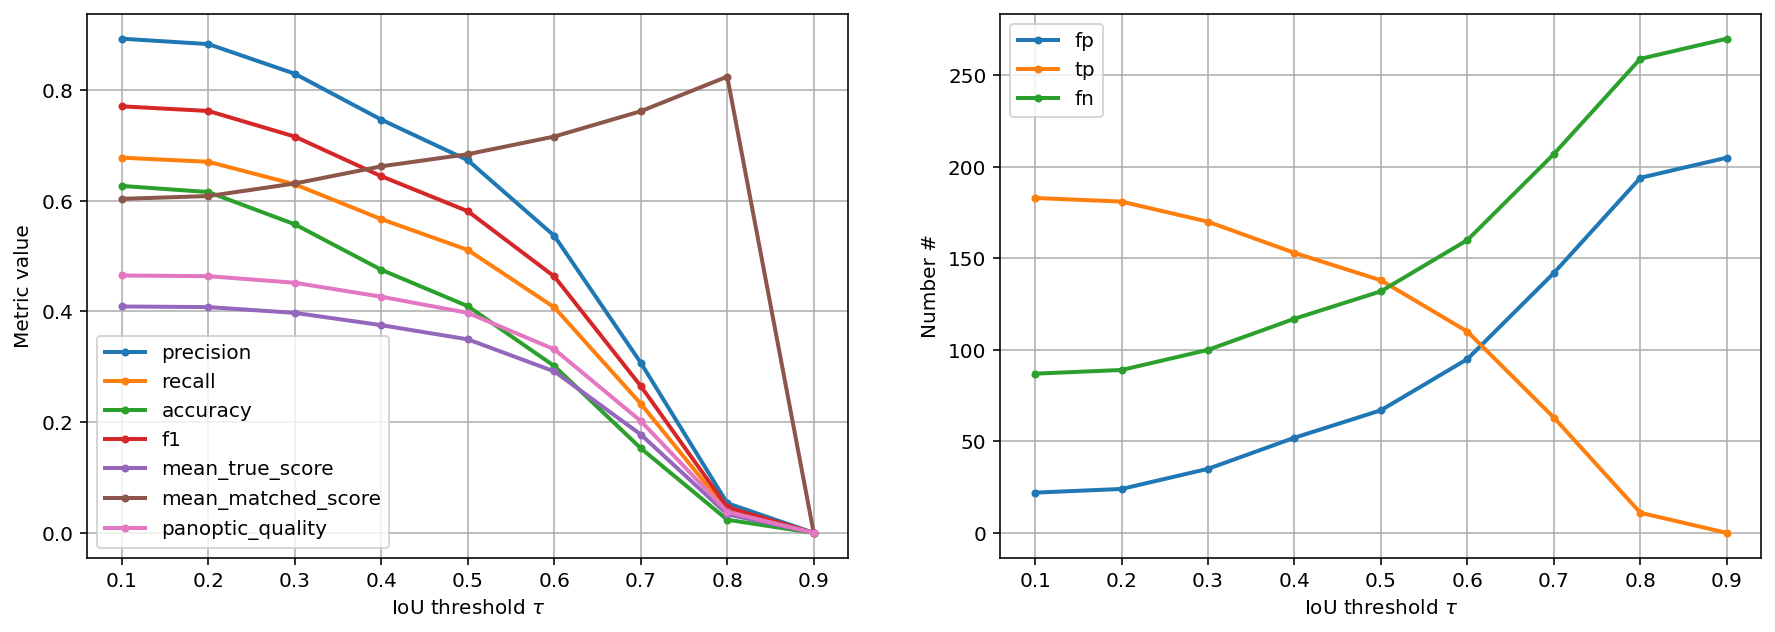

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [ ]:
###Export model to tensorflow

In [ ]:
model.export_TF()